# lighteval is your AI evaluation library

This notebook explores how you can use lighteval to evaluate and compare LLMs.

`lighteval` has been around a while and it's a great tool for getting eval score on major benchmarks. It's just been refactored to support being used like a library in Python, which makes it great for comparing models across benchmarks.

So let's dig in to some eval scores.

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Exercise: Evaluate Your Own Model</h2>
    <p>Now that you've seen how to evaluate models on specific domains, try evaluating a model on a domain that interests you.</p>
    <p><b>Difficulty Levels</b></p>
    <p>🐢 Use the existing medical domain tasks but evaluate a different model from the Hugging Face hub</p>
    <p>🐕 Create a new domain evaluation by selecting different MMLU tasks (e.g., computer science, mathematics, physics)</p>
    <p>🦁 Create a custom evaluation task using LightEval's task framework and evaluate models on your specific domain</p>
</div>

## Install dependencies

In [1]:
!pip install -qqq -U "torch<2.5" "torchvision<2.5" "torchaudio<2.5" --index-url https://download.pytorch.org/whl/cu121
!pip list | grep torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.1 MB/s eta 0:00:00
torch                              2.4.1+cu121
torchaudio                         2.4.1+cu121
torchsummary                       1.5.1
torchvision                        0.19.1+cu121


In [2]:
!pip install -qqq git+https://github.com/huggingface/lighteval.git tiktoken

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Setup `lighteval` evaluation

We need to setup the evaluation environment and pipeline. Much of this we will disable because we're keeping things in the notebook, but we could also use `push_to_hub` or `push_to_tensorboard`.

### `push_to_hub`

This is useful if we're evaluating a model and want to persist its evaluation with weights and configuration on the Hugging Face hub.

### `push_to_tensorboard`

This would be useful if we were building an evaluation tool or script, where we wanted to view results within tensorboard.

In [5]:
import lighteval
import os
from datetime import timedelta
from transformers import AutoModelForCausalLM

from lighteval.logging.evaluation_tracker import EvaluationTracker
# from lighteval.logging.hierarchical_logger import hlog_warn, htrack
# from lighteval.models.model_config import create_model_config
from lighteval.pipeline import EnvConfig, ParallelismManager, Pipeline, PipelineParameters

TOKEN = os.getenv("HF_TOKEN")

In [6]:
env_config = EnvConfig(token=TOKEN, cache_dir="~/tmp")

evaluation_tracker = EvaluationTracker(
    output_dir="~/tmp",
    save_details=False,
    push_to_hub=False,
    push_to_tensorboard=False,
    public=False,
    hub_results_org=False,
)

pipeline_params = PipelineParameters(
    launcher_type=ParallelismManager.ACCELERATE,
    env_config=env_config,
    job_id=1,
    override_batch_size=1,
    num_fewshot_seeds=0,
    max_samples=10,
    use_chat_template=False,
)

# Compares models with `lighteval`

We are going to compare two small LLMs on a domain. We will use `Qwen2.5-0.5B` and `SmolLM2-360M-Instruct` and we will evaluate them on a medical domain.

We can create a domain evaluation from a subset of MMLU evaluations, by defining the evaluation tasks. In lighteval, tasks are described as strings.

`{suite}|{task}:{subtask}|{num_few_shot}|{0 or 1 to reduce num_few_shot if prompt is too long}`

Therefore, we will pass our list of medicine related tasks like this:

```
"leaderboard|mmlu:anatomy|5|0,leaderboard|mmlu:professional_medicine|5|0,leaderboard|mmlu:high_school_biology|5|0,leaderboard|mmlu:high_school_chemistry|5|0"
```

Which can be translated to :

| Suite | Task | Num Fewshot Example | Limit Fewshots |
|---|---|---|---|
| leaderboard | mmlu:anatomy | 5 | False |
| leaderboard | mmlu:professional_medicine | 5 | False |
| leaderboard | mmlu:high_school_biology | 5 | False |
| leaderboard | mmlu:high_school_chemistry | 5 | False |

For a full list of lighteval supported tasks. Checkout this page in [the documentation](https://github.com/huggingface/lighteval/wiki/Available-Tasks).

In [7]:
domain_tasks = "leaderboard|mmlu:anatomy|5|0,leaderboard|mmlu:professional_medicine|5|0,leaderboard|mmlu:high_school_biology|5|0,leaderboard|mmlu:high_school_chemistry|5|0"

# Evaluate Qwen2.5 0.5B

In [8]:
qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B")

pipeline = Pipeline(
    tasks=domain_tasks,
    pipeline_parameters=pipeline_params,
    evaluation_tracker=evaluation_tracker,
    model=qwen_model
)

pipeline.evaluate()

qwen_results = pipeline.get_results()

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/39.7k [00:00<?, ?B/s]

mmlu.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

0000.parquet:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/310 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

0000.parquet:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/8.31k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/203 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

0000.parquet:   0%|          | 0.00/125k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/8.45k [00:00<?, ?B/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/272 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (334 > 20). Running this sequence through the model will result in indexing errors
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:02<00:00, 15.70it/s]
1it [00:02,  2.56s/it]
100%|██████████| 40/40 [00:01<00:00, 22.35it/s]
2it [00:04,  2.12s/it]
100%|██████████| 40/40 [00:01<00:00, 32.46it/s]
3it [00:05,  1.72s/it]
100%|██████████| 40/40 [00:01<00:00, 32.32it/s]
4it [00:06,  1.72s/it]


# Evaluate SmolLM 360M

In [9]:
smol_model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-360M-Instruct")

pipeline = Pipeline(
    tasks=domain_tasks,
    pipeline_parameters=pipeline_params,
    evaluation_tracker=evaluation_tracker,
    model=smol_model
)

pipeline.evaluate()

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (341 > 20). Running this sequence through the model will result in indexing errors
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:01<00:00, 24.67it/s]
1it [00:01,  1.63s/it]
100%|██████████| 40/40 [00:01<00:00, 26.17it/s]
2it [00:03,  1.57s/it]
100%|██████████| 40/40 [00:01<00:00, 27.17it/s]
3it [00:04,  1.53s/it]
100%|██████████| 40/40 [00:01<00:00, 26.64it/s]
4it [00:06,  1.54s/it]


In [10]:
smol_results = pipeline.get_results()

In [11]:
pipeline.show_results()

|                  Task                  |Version|Metric|Value |   |Stderr|
|----------------------------------------|------:|------|-----:|---|-----:|
|all                                     |       |acc   |0.3333|±  |0.1169|
|leaderboard:mmlu:_average:5             |       |acc   |0.3400|±  |0.1121|
|leaderboard:mmlu:anatomy:5              |      0|acc   |0.4500|±  |0.1141|
|leaderboard:mmlu:high_school_biology:5  |      0|acc   |0.1500|±  |0.0819|
|leaderboard:mmlu:high_school_chemistry:5|      0|acc   |0.3500|±  |0.1094|
|leaderboard:mmlu:professional_medicine:5|      0|acc   |0.4500|±  |0.1141|



# Visualize Results

Now that we have results from the two models we can visualize them side-by-side. We'll keep visualisation simple here, but with this data structure you could represent scores in many ways.

<Axes: >

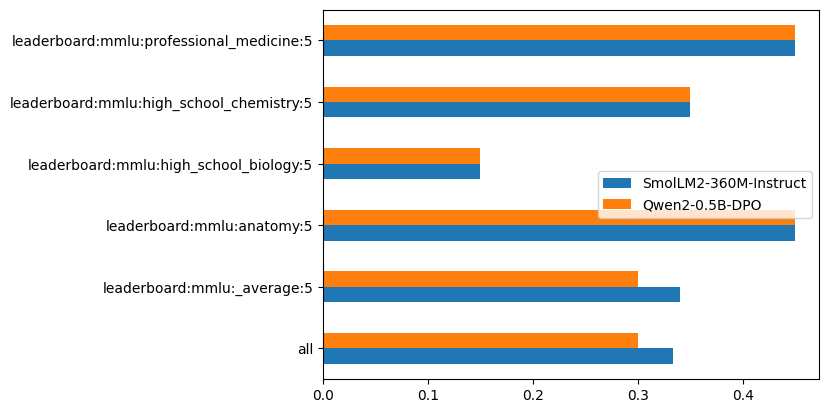

In [12]:
import pandas as pd

df = pd.DataFrame.from_records(smol_results["results"]).T["acc"].rename("SmolLM2-360M-Instruct")
_df = pd.DataFrame.from_records(qwen_results["results"]).T["acc"].rename("Qwen2-0.5B-DPO")
df = pd.concat([df, _df], axis=1)
df.plot(kind="barh")

# 💐 That's it!

You have a handy notebook to view model evals. You could use this to:

- select the right model for your inference use case
- evaluate checkpoints during training
- share model scores

🏃Next Steps

- If you want to go deeper into your evaluation results check out this [notebook](https://github.com/huggingface/evaluation-guidebook/blob/main/contents/examples/comparing_task_formulations.ipynb)
